# LSTM Model 3 on kaggle competition dataset 

Here you can see a multi-input (title and text column) model was created, where the two previous architectures (LSTM1 and LSTM2) are merged in one. 
This model is done by Andrii Shchur, 2020
Here is its [article](https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052)
![image.png](../../images/model3.png)

Complete dataset cannot be distributed because of Twitter privacy policies and news publisher copy rights. Social engagements and user information are not disclosed because of Twitter Policy.  

The minimalistic version of latest dataset provided in this repo (located in dataset folder) include following files:

- politifact_fake.csv - Samples related to fake news collected from PolitiFact
- politifact_real.csv - Samples related to real news collected from PolitiFact

Each of the above CSV files is comma separated file and have the following columns

- id - Unique identifider for each news
- url - Url of the article from web that published that news
- title - Title of the news article
- tweet_ids - Tweet ids of tweets sharing the news. This field is list of tweet ids separated by tab.

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

### <span style="background-color: #FFFF00">In this notebook, I have kept the orogonal validation techenique and the oroginal preprocessing of the dataset </span>

## Importing packages 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import time
#Loading tensorflow and keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import plot_model
from tensorflow.keras.layers import Input
#Loading ntlk
import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer
#Loading sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
#Loading K-folds
from sklearn.model_selection import StratifiedKFold
#Loading the model 
import sys  
sys.path.insert(0, '../../models')
from PY.model3 import get_model

## Paths 

In [5]:
DATA_DIR = '../../../../Data'
CODE_DIR_H5='../../models/H5'
# Create a path for the saving location of the model
MODEL_DIR_H5 = CODE_DIR_H5 + '/model3_Politifact.h5'

## Loading data 

In [7]:
# Load train data
train = pd.read_csv(op.join(DATA_DIR, 'politifact/Claims_to_work_with/claims.csv'))
train

author  label  \
0                                            Paul LePage      1   
1                                     Battleground Texas      0   
2                                     Battleground Texas      0   
3                                         Suzanne Somers      0   
4                                           Jamie Oliver      0   
...                                                  ...    ...   
10459                                       Bill O'Neill      1   
10460                                       Presente.org      0   
10461                                       Presente.org      1   
10462  Local 799 of the International Assoc. of Fire ...      1   
10463                                     Jason Chaffetz      1   

                                                   title  
0      About 47 percent of able-bodied people in the ...  
1      Says Dan Patrick has "called immigration into ...  
2      In 2008, "only 54 percent of Latinos in Texas ...  
3      Even after Obamacare is fully implemented, the...  
4      McDonald's in England only sells organic milk ...  
...                                                  ...  
10459  In recent years, Rep. LaTourette has sponsored...  
10460  91 percent of Latinos support the DREAM Act, w...  
10461  Rep. Adam Putnam was silent when Rush Limbaugh...  
10462  Elorza wants to teach our public school childr...  
10463  We had people that were getting killed (in Ben...  

[10464 rows x 3 columns]

In [4]:
# get label
X_train=train.drop('label',axis=1)
y_train=train['label']

In [5]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [6]:
#dataset Preprocessing
ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

In [7]:
# One hot representation
onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

In [8]:
# sequences representation
sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

In [9]:
# check shape 
print(len(embedded_doc_title),y_train.shape)
print(len(embedded_doc_text),y_train.shape)

20800 (20800,)
20800 (20800,)


In [10]:
# final data for NN
X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
y_final=np.array(y_train)
print(X_final_title.shape,y_final.shape)
print(X_final_text.shape,y_final.shape)

(20800, 20) (20800,)
(20800, 1000) (20800,)


In [11]:
embedding_vector_feature_title = 10
embedding_vector_feature_text = 100
input_title = Input(shape=(sent_length_title,))
input_text = Input(shape=(sent_length_text,))

In [12]:
start=time.time()
model=get_model(vo_size,embedding_vector_feature_title,embedding_vector_feature_text,input_title,input_text)
history = model.fit(x=[X_final_title,X_final_text], y=y_final, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
scores = model.evaluate(x=[X_final_title,X_final_text], y=y_final, verbose=0)
end=time.time()

Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 691s 42ms/sample - loss: 0.4202 - accuracy: 0.8044 - precision_mesure: 0.8016 - recall_mesure: 0.8603 - f1_mesure: 0.8168 - val_loss: 0.2171 - val_accuracy: 0.9291 - val_precision_mesure: 0.8944 - val_recall_mesure: 0.9751 - val_f1_mesure: 0.9324
Epoch 2/10
16640/16640 [==============================] - 736s 44ms/sample - loss: 0.1501 - accuracy: 0.9453 - precision_mesure: 0.9340 - recall_mesure: 0.9585 - f1_mesure: 0.9454 - val_loss: 0.1249 - val_accuracy: 0.9529 - val_precision_mesure: 0.9546 - val_recall_mesure: 0.9511 - val_f1_mesure: 0.9525
Epoch 3/10
16640/16640 [==============================] - 1131s 68ms/sample - loss: 0.1022 - accuracy: 0.9629 - precision_mesure: 0.9522 - recall_mesure: 0.9750 - f1_mesure: 0.9630 - val_loss: 0.1006 - val_accuracy: 0.9635 - val_precision_mesure: 0.9582 - val_recall_mesure: 0.9703 - val_f1_mesure: 0.9640
Epoch 4/10
16640/16640 [===========

In [14]:
# Save the model
model.save(MODEL_DIR_H5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    50000       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1000, 128)    117248      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           lstm_1[0][0]                     
______________________________________________________________________________________________

In [15]:
print("accuracy","%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("precision","%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
print("recall","%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
print("f1-mesure","%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))

accuracy accuracy: 99.12%
precision precision_mesure: 99.23%
recall recall_mesure: 99.02%
f1-mesure f1_mesure: 99.10%


In [16]:
print('time of training' , end-start)

time of training 18105.289485931396


## Graphs 

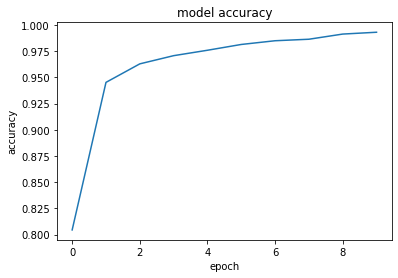

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

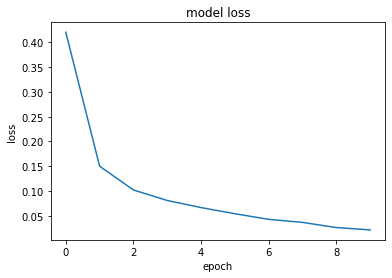

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

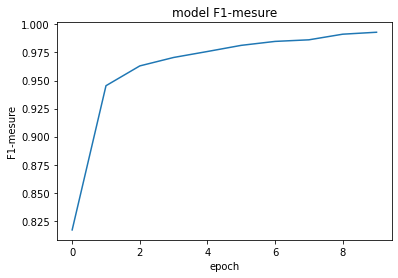

In [19]:
# summarize history for f1-mesure
plt.plot(history.history['f1_mesure'])
plt.title('model F1-mesure')
plt.ylabel('F1-mesure')
plt.xlabel('epoch')
plt.show()

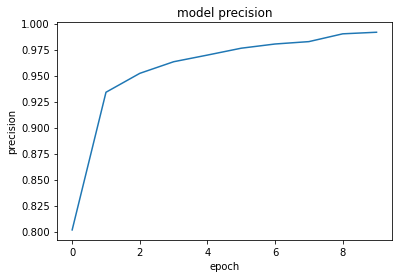

In [20]:
# summarize history for precision
plt.plot(history.history['precision_mesure'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

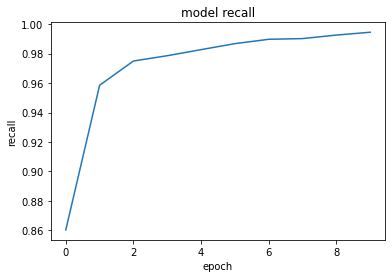

In [21]:
# summarize history for recall
plt.plot(history.history['recall_mesure'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()